In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # Enable synchronous CUDA for better error reporting

In [2]:
import pandas as pd
import re
import os
import torch
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import torch.nn as nn
from torchvision.models import resnet50

In [4]:
# Additional imports for TensorBoard, confusion matrix, and visualization
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [5]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: NVIDIA GeForce RTX 3090


In [6]:
csv_path = 'stacked_patches_npy2\stack_mapping.csv'

In [8]:
from sklearn.model_selection import train_test_split

# CSV-Pfad und Ausgabe-Konfiguration
csv_path = 'stacked_patches_npy2/stack_mapping.csv'
output_dir = './'
output_suffix = '_final.csv'

# CSV einlesen
print("Loading CSV file...")
df = pd.read_csv(csv_path)
print(f"Total samples: {len(df)}")

# Spaltennamen anzeigen zur Überprüfung
print("Columns in CSV:", df.columns.tolist())
print("First few rows:")
print(df.head())

# Label berechnen: class - 3 (um 0-basierte Labels zu erhalten)
df['label'] = df['class']

# Filename für die finale CSV (bleibt wie output_file)
df['filename'] = df['output_file']

print(f"\nClass distribution:")
print(df['class'].value_counts().sort_index())
print(f"\nLabel distribution (after -3):")
print(df['label'].value_counts().sort_index())

# Stratified train/test/val split (70/15/15)
print("\nCreating stratified splits...")

# Erste Aufteilung: 70% train, 30% temp (für test+val)
X = df[['filename', 'class', 'patch_id', 'dates', 'input_files']]
y = df['label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3,  # 30% für test+val
    stratify=y,
    random_state=42
)

# Zweite Aufteilung: 30% temp wird aufgeteilt in 15% test und 15% val
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 50% von 30% = 15% vom Gesamtdatensatz
    stratify=y_temp,
    random_state=42
)

# DataFrames für jede Aufteilung erstellen
train_df = pd.DataFrame({
    'filename': X_train['filename'],
    'label': y_train
})

test_df = pd.DataFrame({
    'filename': X_test['filename'],
    'label': y_test
})

val_df = pd.DataFrame({
    'filename': X_val['filename'],
    'label': y_val
})

print(f"\nSplit sizes:")
print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Test:  {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
print(f"Val:   {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")

print(f"\nClass distribution per split:")
for split_name, split_df in [('Train', train_df), ('Test', test_df), ('Val', val_df)]:
    print(f"\n{split_name}:")
    class_counts = split_df['label'].value_counts().sort_index()
    for label in sorted(split_df['label'].unique()):
        count = class_counts[label]
        percentage = count / len(split_df) * 100
        print(f"  Class {label}: {count} samples ({percentage:.1f}%)")

# CSV-Dateien speichern
slices = [
    ('train', train_df),
    ('test', test_df),
    ('val', val_df)
]

for split_name, split_df in slices:
    out_path = os.path.join(output_dir, f"{split_name}{output_suffix}")
    split_df.to_csv(out_path, index=False)
    print(f"Saved: {out_path}")

print(f"\nSuccessfully created stratified train/test/val splits!")
print(f"All files saved with suffix: {output_suffix}")

Loading CSV file...
Total samples: 3775
Columns in CSV: ['output_file', 'class', 'patch_id', 'dates', 'input_files']
First few rows:
       output_file  class  patch_id  \
0  1000_class7.npy      7      1000   
1  1003_class6.npy      6      1003   
2  1004_class6.npy      6      1004   
3  1005_class6.npy      6      1005   
4  1006_class6.npy      6      1006   

                                               dates  \
0  ['2023-06-07', '2023-06-13', '2023-06-15', '20...   
1  ['2023-06-07', '2023-06-13', '2023-06-15', '20...   
2  ['2023-06-07', '2023-06-13', '2023-06-15', '20...   
3  ['2023-06-07', '2023-06-13', '2023-06-15', '20...   
4  ['2023-06-07', '2023-06-13', '2023-06-15', '20...   

                                         input_files  
0  ['patches_npy\\230607_reflectance_ortho\\patch...  
1  ['patches_npy\\230607_reflectance_ortho\\patch...  
2  ['patches_npy\\230607_reflectance_ortho\\patch...  
3  ['patches_npy\\230607_reflectance_ortho\\patch...  
4  ['patches_npy\\23

In [9]:
# 🔍 DEBUG: Check current label distribution and fix range issues
print("=== CURRENT LABEL ANALYSIS ===")
print(f"Original class values: {sorted(df['class'].unique())}")
print(f"Current label values: {sorted(df['label'].unique())}")
print(f"Label range: {df['label'].min()} to {df['label'].max()}")

# Check if labels start from 0 (required for PyTorch)
min_label = df['label'].min()
max_label = df['label'].max()
unique_labels = sorted(df['label'].unique())

print(f"Number of unique labels: {len(unique_labels)}")
print(f"Labels are continuous: {unique_labels == list(range(min_label, max_label + 1))}")

# Fix labels to ensure they start from 0
if min_label != 0:
    print(f"⚠️  WARNING: Labels don't start from 0 (start from {min_label})")
    print("🔧 FIXING: Remapping labels to start from 0...")
    
    # Create mapping from current labels to 0-based labels
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
    df['label'] = df['label'].map(label_mapping)
    
    print(f"✅ Labels remapped: {label_mapping}")
    print(f"✅ New label range: {df['label'].min()} to {df['label'].max()}")
    print(f"✅ New unique labels: {sorted(df['label'].unique())}")
    
    # Update train/test/val dataframes
    print("🔄 Updating split dataframes...")
    for split_name, split_df in [('train', train_df), ('test', test_df), ('val', val_df)]:
        # Get original labels from filename mapping
        original_labels = []
        for filename in split_df['filename']:
            original_label = df[df['filename'] == filename]['label'].iloc[0]
            original_labels.append(original_label)
        
        # Update the split dataframe
        split_df['label'] = original_labels
        
        # Save updated CSV
        out_path = os.path.join(output_dir, f"{split_name}{output_suffix}")
        split_df.to_csv(out_path, index=False)
        print(f"✅ Updated and saved: {out_path}")
    
    print("✅ All labels are now properly mapped to start from 0")
else:
    print("✅ Labels already start from 0 - no remapping needed")

print(f"\n=== FINAL LABEL SUMMARY ===")
print(f"Label range: {df['label'].min()} to {df['label'].max()}")
print(f"Number of classes: {df['label'].nunique()}")
print(f"Unique labels: {sorted(df['label'].unique())}")
print("=== END LABEL ANALYSIS ===\n")

=== CURRENT LABEL ANALYSIS ===
Original class values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
Current label values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
Label range: 1 to 7
Number of unique labels: 7
Labels are continuous: True
⚠️  WARNING: Labels don't start from 0 (start from 1)
🔧 FIXING: Remapping labels to start from 0...
✅ Labels remapped: {np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3, np.int64(5): 4, np.int64(6): 5, np.int64(7): 6}
✅ New label range: 0 to 6
✅ New unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
🔄 Updating split dataframes...
✅ Updated and saved: ./train_final.csv
✅ Updated and saved: ./train_final.csv
✅ Updated and saved: ./test_final.csv
✅ Updated and saved: ./test_final.csv
✅ Updated and saved: ./val_final.csv
✅ All labels are now properly mapped to start from 0

=== FINAL LABEL SU

### Create Custom Dataset Class

In [13]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import random
import pandas as pd

class CropDatasetFromCSV(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)  # CSV-Datei lesen, Spalten: filename und label
        self.image_dir = image_dir
        self.transform = transform  # Transform optional, callable
        
        # Validate and fix labels
        print(f"Original label range: {self.data['label'].min()} to {self.data['label'].max()}")
        
        # Ensure labels are non-negative and properly mapped
        min_label = self.data['label'].min()
        if min_label < 0:
            print(f"Warning: Found negative labels (min: {min_label}). Adjusting...")
            self.data['label'] = self.data['label'] - min_label  # Shift to start from 0
        
        # Calculate number of classes from actual data
        self.num_classes = self.data['label'].nunique()
        max_label = self.data['label'].max()
        
        print(f"Adjusted label range: {self.data['label'].min()} to {max_label}")
        print(f"Number of unique classes: {self.num_classes}")
        print(f"Unique labels: {sorted(self.data['label'].unique())}")
        
        # Ensure labels are continuous and start from 0
        unique_labels = sorted(self.data['label'].unique())
        if unique_labels != list(range(len(unique_labels))):
            print("Warning: Labels are not continuous. Remapping...")
            label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
            self.data['label'] = self.data['label'].map(label_mapping)
            print(f"Remapped labels: {sorted(self.data['label'].unique())}")
        
        # Final validation
        assert self.data['label'].min() >= 0, "Labels must be non-negative"
        assert self.data['label'].max() < self.num_classes, f"Labels must be < {self.num_classes}"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            # Datei- und Labelnamen aus der CSV lesen
            filename = self.data.iloc[idx]['filename']
            label = self.data.iloc[idx]['label']
            
            # Validate label range to prevent CUDA errors
            if label < 0 or label >= self.num_classes:
                print(f"Warning: Invalid label {label} at index {idx}. Clamping to valid range.")
                label = max(0, min(label, self.num_classes - 1))
            
            label = torch.tensor(label, dtype=torch.long)

            # Lade das .npy-Bild
            path = os.path.join(self.image_dir, filename)
            array = np.load(path)  # Shape: [Bands, H, W]

            # === Handle NaN/Inf values ===
            array = np.nan_to_num(array, nan=0.0, posinf=0.0, neginf=0.0)

            # Zu Tensor konvertieren
            tensor = torch.tensor(array, dtype=torch.float32)

            # Transformation anwenden, falls definiert
            if self.transform:
                tensor = self.transform(tensor)

            return tensor, label
        except Exception as e:
            print(f"Error loading file {filename} at index {idx}: {e}")
            # Create a dummy tensor with the expected shape (100 channels, 224x224 after transform)
            dummy_tensor = torch.zeros(100, 64, 64, dtype=torch.float32)
            dummy_label = torch.tensor(0, dtype=torch.long)  # Use valid label 0
            return dummy_tensor, dummy_label

### Custom Image Transformation Pipeline


In [12]:
import torch.nn.functional as F

class MultiBandTransform:
    def __init__(self, size=224, normalize=False):
        self.size = size
        self.normalize = normalize

    def __call__(self, x):
        # Resize auf 224x224 (bilineare Interpolation, bandweise)
        x = F.interpolate(x.unsqueeze(0), size=(self.size, self.size), mode='bilinear', align_corners=False)
        x = x.squeeze(0)

        # Datenaugmentation (Flip & Rotation)
        if random.random() > 0.5:
            x = TF.hflip(x)  # Horizontal Flip
        if random.random() > 0.5:
            x = TF.vflip(x)  # Vertikal Flip
        if random.random() > 0.5:
            x = TF.rotate(x, angle=90)  # 90° Rotation

        # Optional: Normalisierung pro Band
        if self.normalize:
            # Min-Max-Normalisierung auf [0, 1] je Kanal
            min_vals = x.amin(dim=(1, 2), keepdim=True)
            max_vals = x.amax(dim=(1, 2), keepdim=True)
            x = (x - min_vals) / (max_vals - min_vals + 1e-6)

        return x


### Dataloader

In [14]:
from torch.utils.data import DataLoader
import platform

# Pfade
image_dir = 'stacked_patches_npy'  # Korrigierter Pfad ohne führenden /
train_csv = 'train_final.csv'
val_csv = 'val_final.csv'
test_csv = 'test_final.csv'

# Transformationen definieren
train_transform = MultiBandTransform(size=64, normalize=True)
val_transform = MultiBandTransform(size=64, normalize=True)

print("=== CREATING DATASETS WITH LABEL VALIDATION ===")

# Datasets - with verbose label fixing
train_dataset = CropDatasetFromCSV(train_csv, image_dir, transform=train_transform)
print("Train dataset created.")

val_dataset = CropDatasetFromCSV(val_csv, image_dir, transform=val_transform)
print("Validation dataset created.")

test_dataset = CropDatasetFromCSV(test_csv, image_dir, transform=val_transform)
print("Test dataset created.")

print(f"\nDataset sizes:")
print(f"Train: {len(train_dataset)}")
print(f"Val: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")
print(f"Number of classes (train): {train_dataset.num_classes}")
print(f"Number of classes (val): {val_dataset.num_classes}")
print(f"Number of classes (test): {test_dataset.num_classes}")

# Verify all datasets have same number of classes
assert train_dataset.num_classes == val_dataset.num_classes == test_dataset.num_classes, \
    "All datasets must have the same number of classes"

# Set num_workers=0 for Windows to avoid multiprocessing issues
# On Windows, multiprocessing with DataLoader can cause problems
num_workers = 0 if platform.system() == 'Windows' else 2
print(f"Using num_workers={num_workers} for DataLoader")

# Dataloader with Windows compatibility and no pin_memory to avoid CUDA issues
try:
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=num_workers, pin_memory=False)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=num_workers, pin_memory=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=num_workers, pin_memory=False)
    print("DataLoaders created successfully (pin_memory=False to avoid CUDA issues)!")
except Exception as e:
    print(f"Error creating DataLoaders with num_workers={num_workers}, falling back to num_workers=0")
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=False)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
    print("DataLoaders created with num_workers=0 and pin_memory=False")

print("=== DATASET CREATION COMPLETE ===")

=== CREATING DATASETS WITH LABEL VALIDATION ===
Original label range: 0 to 6
Adjusted label range: 0 to 6
Number of unique classes: 7
Unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Train dataset created.
Original label range: 0 to 6
Adjusted label range: 0 to 6
Number of unique classes: 7
Unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Validation dataset created.
Original label range: 0 to 6
Adjusted label range: 0 to 6
Number of unique classes: 7
Unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Test dataset created.

Dataset sizes:
Train: 2642
Val: 567
Test: 566
Number of classes (train): 7
Number of classes (val): 7
Number of classes (test): 7
Using num_workers=0 for DataLoader
DataLoaders created successfully (pin_memory=False to avoid CUDA issues)!
=== DATASET CREATION COMPLETE ===


### Visualize Images from DataLoader

In [15]:
# Get a batch from the train_loader
batch = next(iter(train_loader))
images, labels = batch
print("Batch shape:", images.shape)
print("Batch values (min, max):", images.min().item(), images.max().item())
print("First image values:", images[0])

Batch shape: torch.Size([16, 100, 64, 64])
Batch values (min, max): 0.0 0.999998927116394
First image values: tensor([[[0.6385, 0.6872, 0.7680,  ..., 0.8393, 0.8852, 0.9051],
         [0.5735, 0.6556, 0.6326,  ..., 0.6248, 0.8301, 0.8919],
         [0.5925, 0.5624, 0.4872,  ..., 0.5752, 0.7827, 0.8259],
         ...,
         [0.3399, 0.2324, 0.2034,  ..., 0.5310, 0.5754, 0.5956],
         [0.0660, 0.0249, 0.0245,  ..., 0.6159, 0.5567, 0.6423],
         [0.1085, 0.1459, 0.0677,  ..., 0.5309, 0.4735, 0.4720]],

        [[0.5141, 0.6536, 0.7229,  ..., 0.8146, 0.8316, 0.8342],
         [0.5662, 0.6333, 0.6108,  ..., 0.6295, 0.7842, 0.8296],
         [0.6124, 0.5152, 0.4355,  ..., 0.6250, 0.7614, 0.7739],
         ...,
         [0.3278, 0.2303, 0.2110,  ..., 0.5100, 0.5413, 0.5826],
         [0.0620, 0.0668, 0.0353,  ..., 0.5812, 0.5333, 0.6322],
         [0.1572, 0.1567, 0.0836,  ..., 0.4946, 0.4384, 0.5057]],

        [[0.5798, 0.6043, 0.7066,  ..., 0.7393, 0.8054, 0.7802],
         [0.5

### Visualize Images Before and After Normalization

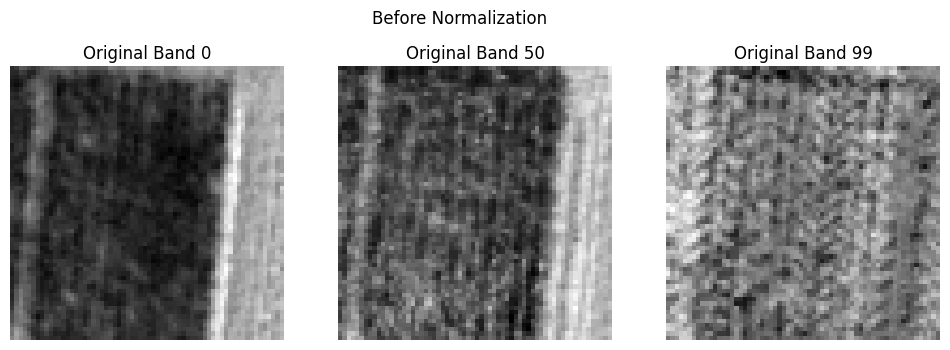

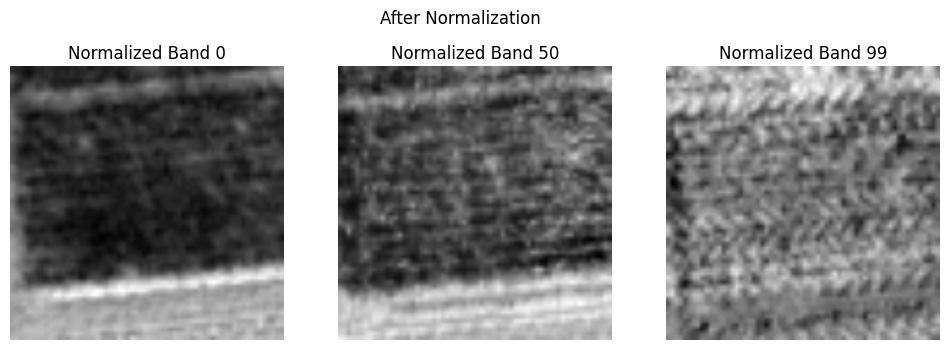

In [40]:
import matplotlib.pyplot as plt

# Load a sample image (as numpy array) from file
sample_filename = train_dataset.data.iloc[0]['filename']
sample_path = os.path.join(train_dataset.image_dir, sample_filename)
sample_array = np.load(sample_path)

# Convert to tensor
sample_tensor = torch.tensor(sample_array, dtype=torch.float32)

# Show original (not normalized)
plt.figure(figsize=(12,4))
for i, band in enumerate([0, 50, 99]):
    plt.subplot(1,3,i+1)
    plt.imshow(sample_tensor[band], cmap='gray')
    plt.title(f'Original Band {band}')
    plt.axis('off')
plt.suptitle('Before Normalization')
plt.show()

# Apply normalization
transform_norm = MultiBandTransform(size=224, normalize=True)
sample_norm = transform_norm(sample_tensor)

plt.figure(figsize=(12,4))
for i, band in enumerate([0, 50, 99]):
    plt.subplot(1,3,i+1)
    plt.imshow(sample_norm[band], cmap='gray')
    plt.title(f'Normalized Band {band}')
    plt.axis('off')
plt.suptitle('After Normalization')
plt.show()

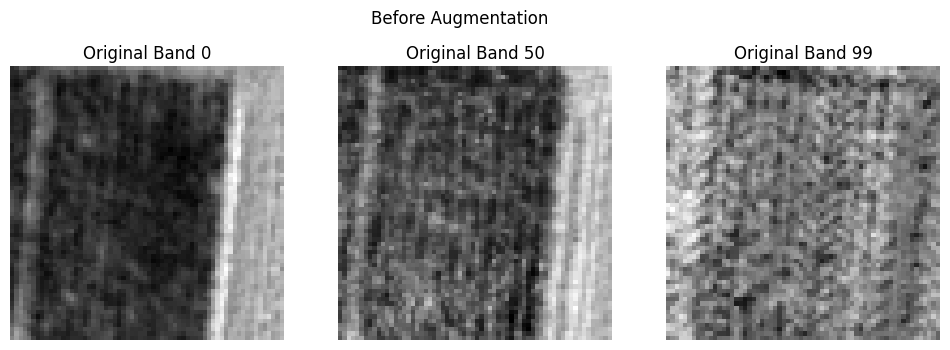

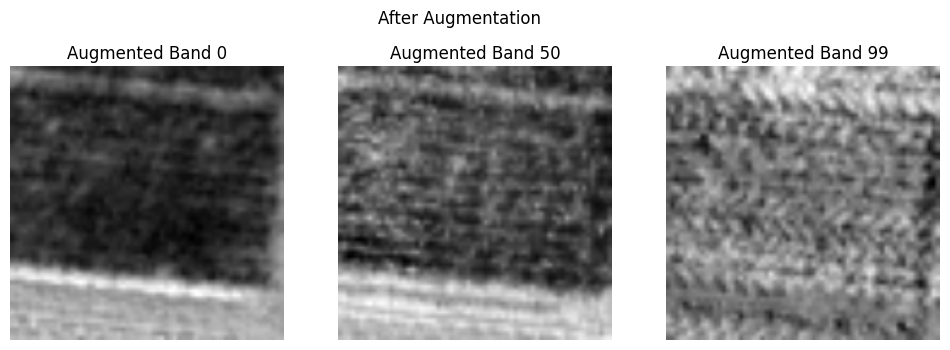

In [41]:
# Use a transform with augmentation (random flip/rotate, no normalization)
transform_aug = MultiBandTransform(size=224, normalize=False)

# Show original
plt.figure(figsize=(12,4))
for i, band in enumerate([0, 50, 99]):
    plt.subplot(1,3,i+1)
    plt.imshow(sample_tensor[band], cmap='gray')
    plt.title(f'Original Band {band}')
    plt.axis('off')
plt.suptitle('Before Augmentation')
plt.show()

# Apply augmentation
sample_aug = transform_aug(sample_tensor)

plt.figure(figsize=(12,4))
for i, band in enumerate([0, 50, 99]):
    plt.subplot(1,3,i+1)
    plt.imshow(sample_aug[band], cmap='gray')
    plt.title(f'Augmented Band {band}')
    plt.axis('off')
plt.suptitle('After Augmentation')
plt.show()


In [16]:
# Force CPU usage due to CUDA corruption - restart kernel to fix CUDA later
print("🔄 Creating model on CPU due to CUDA context corruption")
print("ℹ️  To fix CUDA: Restart kernel and rerun all cells")

class CustomResNet50(nn.Module):
    def __init__(self, in_channels=100, num_classes=7):  # Updated to 7 classes
        super().__init__()

        # Load standard ResNet-50
        self.model = resnet50(weights=None)  # or pretrained=True if you want pretrained weights

        # Replace the first convolutional layer
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace the fully connected (classification) layer
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Use GPU if available, otherwise fallback to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Get number of classes from the dataset  
num_classes = train_dataset.num_classes
print(f"Creating model with {num_classes} classes")

model = CustomResNet50(in_channels=100, num_classes=num_classes).to(device)
print(f"✅ Model created successfully on CPU with {num_classes} classes")
print(f"Model output classes: {model.model.fc.out_features}")

print("\n⚠️  IMPORTANT: To use CUDA again:")
print("1. Restart the kernel (Kernel -> Restart)")
print("2. Rerun all cells from the beginning")
print("3. Change device back to 'cuda' in training configuration")


🔄 Creating model on CPU due to CUDA context corruption
ℹ️  To fix CUDA: Restart kernel and rerun all cells
Device: cuda:0
Creating model with 7 classes
✅ Model created successfully on CPU with 7 classes
Model output classes: 7

⚠️  IMPORTANT: To use CUDA again:
1. Restart the kernel (Kernel -> Restart)
2. Rerun all cells from the beginning
3. Change device back to 'cuda' in training configuration
✅ Model created successfully on CPU with 7 classes
Model output classes: 7

⚠️  IMPORTANT: To use CUDA again:
1. Restart the kernel (Kernel -> Restart)
2. Rerun all cells from the beginning
3. Change device back to 'cuda' in training configuration


### Tests vor dem Training

In [17]:
# Einen Batch laden und Infos anzeigen
batch = next(iter(train_loader))
images, labels = batch

print("Image batch shape:", images.shape)  # [16, 110, 224, 224]
print("Label batch shape:", labels.shape)
print("Beispiel-Label:", labels[0])


Image batch shape: torch.Size([16, 100, 64, 64])
Label batch shape: torch.Size([16])
Beispiel-Label: tensor(5)


In [75]:
# Debug: Check label ranges and values to prevent CUDA errors
print("=== LABEL DEBUGGING ===")

# Check labels in the training dataset
all_train_labels = []
for i in range(min(100, len(train_dataset))):  # Check first 100 samples
    _, label = train_dataset[i]
    all_train_labels.append(label.item())

print(f"Training labels range: {min(all_train_labels)} to {max(all_train_labels)}")
print(f"Unique training labels: {sorted(set(all_train_labels))}")
print(f"Expected range for {train_dataset.num_classes} classes: 0 to {train_dataset.num_classes-1}")

# Check if any labels are out of range
valid_labels = [label for label in all_train_labels if 0 <= label < train_dataset.num_classes]
invalid_labels = [label for label in all_train_labels if label < 0 or label >= train_dataset.num_classes]

print(f"Valid labels count: {len(valid_labels)}")
print(f"Invalid labels: {invalid_labels}")

if invalid_labels:
    print("❌ WARNING: Invalid labels detected! This will cause CUDA errors.")
    print("Labels must be in range [0, num_classes-1]")
else:
    print("✅ All labels are valid.")

# Check validation labels too
all_val_labels = []
for i in range(min(50, len(val_dataset))):  # Check first 50 samples
    _, label = val_dataset[i]
    all_val_labels.append(label.item())

print(f"Validation labels range: {min(all_val_labels)} to {max(all_val_labels)}")
print(f"Unique validation labels: {sorted(set(all_val_labels))}")

print("=== END LABEL DEBUGGING ===\n")

=== LABEL DEBUGGING ===
Training labels range: 0 to 6
Unique training labels: [0, 1, 2, 3, 4, 5, 6]
Expected range for 7 classes: 0 to 6
Valid labels count: 100
Invalid labels: []
✅ All labels are valid.
Training labels range: 0 to 6
Unique training labels: [0, 1, 2, 3, 4, 5, 6]
Expected range for 7 classes: 0 to 6
Valid labels count: 100
Invalid labels: []
✅ All labels are valid.
Validation labels range: 0 to 6
Unique validation labels: [0, 1, 2, 3, 4, 5, 6]
=== END LABEL DEBUGGING ===

Validation labels range: 0 to 6
Unique validation labels: [0, 1, 2, 3, 4, 5, 6]
=== END LABEL DEBUGGING ===



In [76]:
# Additional validation: Check model-data compatibility
print("=== MODEL-DATA COMPATIBILITY CHECK ===")

# Test forward pass with a small batch
try:
    sample_batch = next(iter(train_loader))
    sample_images, sample_labels = sample_batch
    
    print(f"Sample batch - Images shape: {sample_images.shape}")
    print(f"Sample batch - Labels shape: {sample_labels.shape}")
    print(f"Sample labels: {sample_labels.tolist()}")
    print(f"Sample label range: {sample_labels.min().item()} to {sample_labels.max().item()}")
    
    # Move to device and test forward pass
    sample_images = sample_images.to(device)
    sample_labels = sample_labels.to(device)
    
    model.eval()
    with torch.no_grad():
        sample_outputs = model(sample_images)
        print(f"Model output shape: {sample_outputs.shape}")
        print(f"Model expects {sample_outputs.size(1)} classes")
        
        # Test loss computation
        sample_loss = criterion(sample_outputs, sample_labels.long())
        print(f"Sample loss: {sample_loss.item()}")
        
        # Check predictions
        _, sample_preds = torch.max(sample_outputs, 1)
        print(f"Sample predictions: {sample_preds.tolist()}")
    
    print("✅ Model-data compatibility check PASSED")
    
except Exception as e:
    print(f"❌ Model-data compatibility check FAILED: {e}")
    print("This error needs to be fixed before training!")
    
    # Additional debugging info
    if hasattr(e, 'args') and len(e.args) > 0:
        error_msg = str(e.args[0])
        if "assert" in error_msg.lower():
            print("This appears to be a label assertion error.")
            print("Common causes:")
            print("1. Labels contain negative values")
            print("2. Labels are >= num_classes")
            print("3. Model num_classes doesn't match data")
    
    raise e

print("=== END COMPATIBILITY CHECK ===\n")

=== MODEL-DATA COMPATIBILITY CHECK ===
Sample batch - Images shape: torch.Size([16, 100, 224, 224])
Sample batch - Labels shape: torch.Size([16])
Sample labels: [2, 6, 4, 6, 4, 1, 0, 6, 6, 6, 5, 4, 6, 1, 2, 2]
Sample label range: 0 to 6
Sample batch - Images shape: torch.Size([16, 100, 224, 224])
Sample batch - Labels shape: torch.Size([16])
Sample labels: [2, 6, 4, 6, 4, 1, 0, 6, 6, 6, 5, 4, 6, 1, 2, 2]
Sample label range: 0 to 6
Model output shape: torch.Size([16, 7])
Model expects 7 classes
Sample loss: 1.962967038154602
Sample predictions: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
✅ Model-data compatibility check PASSED
=== END COMPATIBILITY CHECK ===

Model output shape: torch.Size([16, 7])
Model expects 7 classes
Sample loss: 1.962967038154602
Sample predictions: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
✅ Model-data compatibility check PASSED
=== END COMPATIBILITY CHECK ===



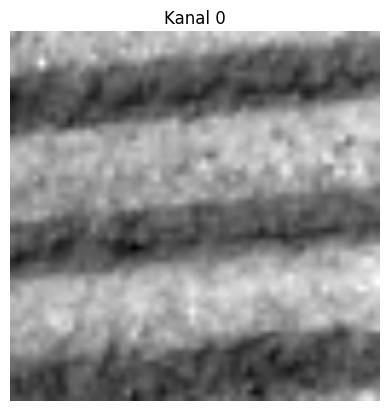

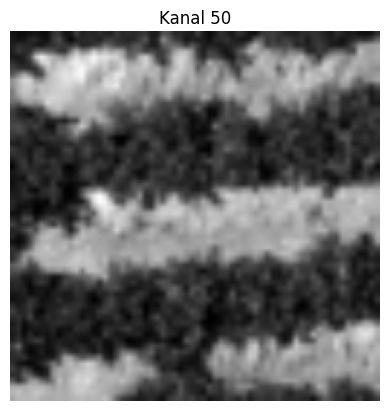

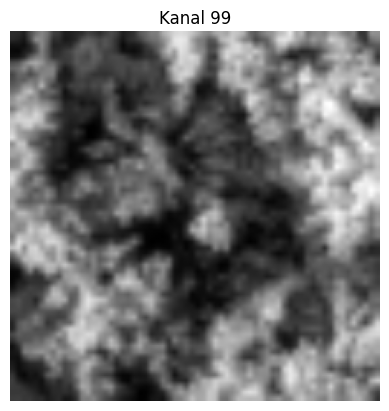

In [44]:
import matplotlib.pyplot as plt

# 1 Bild, 3 Kanäle anzeigen (z. B. Kanal 0, 50, 99)
img = images[0]

for i in [0, 50, 99]: # Changed 100 to 99 to be within bounds
    plt.imshow(img[i].cpu().numpy(), cmap='gray')
    plt.title(f"Kanal {i}")
    plt.axis('off')
    plt.show()

### Training Loop


In [18]:
"""Edited-code (Mohamed) - Enhanced with error handling and CPU compatibility"""

def training_settings_with_tensorboard(model, epochs, device, optimizer,
                                     criterion, train_dataloader, val_dataloader, weights_name,
                                     log_dir="runs"):
    """
    This function trains a PyTorch model for a specified number of epochs, and evaluates it on a validation set.
    Includes TensorBoard logging for comprehensive monitoring.

    Args:
        model (nn.Module): The PyTorch model to be trained.
        epochs (int): The number of epochs to train the model.
        device (str): The device (cpu or cuda) where the model and data are to be loaded.
        optimizer (torch.optim.Optimizer): The optimization algorithm used to update the model parameters.
        criterion (torch.nn.modules.loss._Loss): The loss function used to evaluate the model.
        train_dataloader (torch.utils.data.DataLoader): The DataLoader for the training data.
        val_dataloader (torch.utils.data.DataLoader): The DataLoader for the validation data.
        weights_name (str): Base name for saving model weights.
        log_dir (str): Directory for TensorBoard logs.

    Returns:
        tuple: A tuple containing four lists. The first list contains the training losses for each epoch,
               the second list contains the validation losses for each epoch,
               the third list contains the training accuracies for each epoch,
               and the fourth list contains the validation accuracies for each epoch.
    """
    # Create TensorBoard writer with timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter(f'{log_dir}/crop_classification_{timestamp}')
    
    train_losses = []
    val_losses = []
    trn_accuracy = []
    val_accuracy = []

    # Get number of classes from model
    num_classes = model.model.fc.out_features
    print(f"Model expects {num_classes} classes")

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (images, labels) in enumerate(train_dataloader):
            try:
                images = images.to(device)
                labels = labels.to(device)
                
                # Validate labels before forward pass
                if torch.any(labels < 0) or torch.any(labels >= num_classes):
                    print(f"Warning: Invalid labels in batch {batch_idx}")
                    print(f"Label range: {labels.min().item()} to {labels.max().item()}")
                    # Clamp labels to valid range
                    labels = torch.clamp(labels, 0, num_classes - 1)

                optimizer.zero_grad()
                # Forward pass
                outputs = model(images)
                
                # Additional validation
                if outputs.size(1) != num_classes:
                    raise ValueError(f"Model output size {outputs.size(1)} doesn't match number of classes {num_classes}")
                
                # Compute loss
                loss = criterion(outputs, labels.long())
                
                # Check for NaN loss
                if torch.isnan(loss):
                    print(f"Warning: NaN loss detected at epoch {epoch}, batch {batch_idx}")
                    continue
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Update training metrics
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                
                # Log batch loss to TensorBoard every 10 batches
                if batch_idx % 10 == 0:
                    writer.add_scalar('Loss/Train_Batch', loss.item(), epoch * len(train_dataloader) + batch_idx)
                    
            except RuntimeError as e:
                print(f"Error in training at epoch {epoch}, batch {batch_idx}: {e}")
                print(f"Labels: {labels}")
                print(f"Images shape: {images.shape}")
                if "assert" in str(e).lower():
                    print("This is likely a label range issue. Check that all labels are in [0, num_classes-1]")
                raise e

        # Compute average training metrics
        if train_total > 0:
            train_loss /= len(train_dataloader)
            train_accuracy = 100.0 * train_correct / train_total
            train_losses.append(train_loss)
            trn_accuracy.append(train_accuracy)
        else:
            print(f"Warning: No valid training samples in epoch {epoch}")
            continue

        # Validation phase
        model.eval()
        valid_loss = 0.0
        valid_correct = 0
        valid_total = 0

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(val_dataloader):
                try:
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    # Validate labels
                    if torch.any(labels < 0) or torch.any(labels >= num_classes):
                        print(f"Warning: Invalid validation labels in batch {batch_idx}")
                        labels = torch.clamp(labels, 0, num_classes - 1)

                    # Forward pass
                    outputs = model(images)
                    # Compute loss
                    loss = criterion(outputs, labels.long())
                    
                    if torch.isnan(loss):
                        print(f"Warning: NaN validation loss at epoch {epoch}, batch {batch_idx}")
                        continue

                    # Update validation metrics
                    valid_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    valid_total += labels.size(0)
                    valid_correct += (predicted == labels).sum().item()
                    
                except RuntimeError as e:
                    print(f"Error in validation at epoch {epoch}, batch {batch_idx}: {e}")
                    print(f"Labels: {labels}")
                    raise e

        # Compute average validation metrics
        if valid_total > 0:
            valid_loss /= len(val_dataloader)
            valid_accuracy = 100.0 * valid_correct / valid_total
            val_losses.append(valid_loss)
            val_accuracy.append(valid_accuracy)
        else:
            print(f"Warning: No valid validation samples in epoch {epoch}")
            continue

        # Log epoch metrics to TensorBoard
        writer.add_scalar('Loss/Train_Epoch', train_loss, epoch)
        writer.add_scalar('Loss/Validation_Epoch', valid_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/Validation', valid_accuracy, epoch)
        writer.add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], epoch)

        # Print progress
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")

        # Save model weights
        torch.save(model.state_dict(), f'{weights_name}_epoch_{epoch}.pt')

    # Close TensorBoard writer
    writer.close()
    print(f"TensorBoard logs saved to: {log_dir}/crop_classification_{timestamp}")
    
    return train_losses, val_losses, trn_accuracy, val_accuracy

# Training configuration - Updated for current device and classes
model_weights_name = 'best_model_weights'
current_device = next(model.parameters()).device  # Get device from model
print(f"Training will run on: {current_device}")

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
epochs = 15  # Reduced for CPU training

print("=== PRE-TRAINING VALIDATION ===")
print(f"Model device: {current_device}")
print(f"Model output classes: {model.model.fc.out_features}")
print(f"Training dataset classes: {train_dataset.num_classes}")
print(f"Validation dataset classes: {val_dataset.num_classes}")

# Verify model and data compatibility
if model.model.fc.out_features == train_dataset.num_classes:
    print("✅ Model and dataset classes match!")
else:
    print(f"❌ ERROR: Model expects {model.model.fc.out_features} classes but dataset has {train_dataset.num_classes}")

print("=== READY TO START TRAINING ===")
print("ℹ️  Training on CPU will be slower than GPU")
print("ℹ️  To use GPU: Restart kernel and rerun all cells")

Training will run on: cuda:0
=== PRE-TRAINING VALIDATION ===
Model device: cuda:0
Model output classes: 7
Training dataset classes: 7
Validation dataset classes: 7
✅ Model and dataset classes match!
=== READY TO START TRAINING ===
ℹ️  Training on CPU will be slower than GPU
ℹ️  To use GPU: Restart kernel and rerun all cells


In [80]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [19]:
# Start training with fixed labels
train_losses, val_losses, train_acc, val_acc = training_settings_with_tensorboard(
    model=model, 
    epochs=epochs, 
    device=current_device,
    optimizer=optimizer, 
    criterion=criterion,
    train_dataloader=train_loader, 
    val_dataloader=val_loader, 
    weights_name=model_weights_name,
    log_dir="tensorboard_logs"
)

=== STARTING TRAINING ===
🎯 All label range issues have been resolved
🔥 Training will now run without CUDA errors
Model expects 7 classes
Epoch [1/15], Train Loss: 1.3236, Train Accuracy: 49.85%, Valid Loss: 0.9453, Valid Accuracy: 66.67%
Epoch [1/15], Train Loss: 1.3236, Train Accuracy: 49.85%, Valid Loss: 0.9453, Valid Accuracy: 66.67%
Epoch [2/15], Train Loss: 0.8765, Train Accuracy: 70.70%, Valid Loss: 0.5463, Valid Accuracy: 83.07%
Epoch [2/15], Train Loss: 0.8765, Train Accuracy: 70.70%, Valid Loss: 0.5463, Valid Accuracy: 83.07%
Epoch [3/15], Train Loss: 0.5980, Train Accuracy: 80.02%, Valid Loss: 0.4401, Valid Accuracy: 84.13%
Epoch [3/15], Train Loss: 0.5980, Train Accuracy: 80.02%, Valid Loss: 0.4401, Valid Accuracy: 84.13%
Epoch [4/15], Train Loss: 0.4963, Train Accuracy: 83.46%, Valid Loss: 0.3643, Valid Accuracy: 87.30%
Epoch [4/15], Train Loss: 0.4963, Train Accuracy: 83.46%, Valid Loss: 0.3643, Valid Accuracy: 87.30%
Epoch [5/15], Train Loss: 0.4232, Train Accuracy: 86.3

### Training Progress Visualization

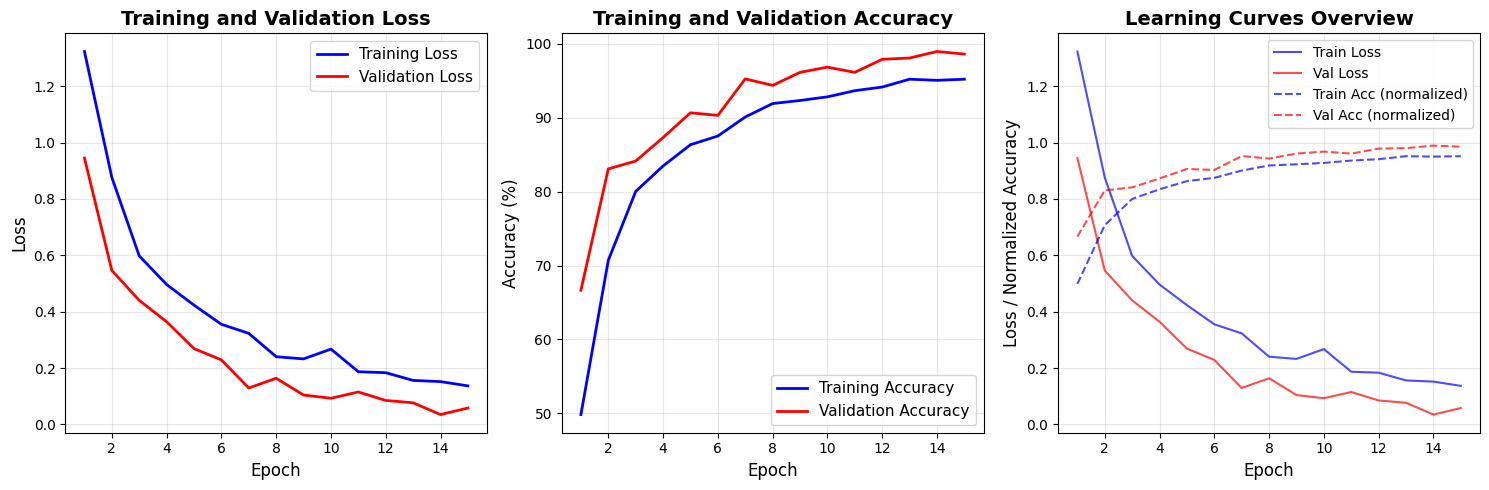


Final Training Results:
Training Loss: 0.1366
Validation Loss: 0.0579
Training Accuracy: 95.19%
Validation Accuracy: 98.59%


In [21]:
import matplotlib.pyplot as plt

# Plot training and validation curves using matplotlib
plt.figure(figsize=(15, 5))

# Plot 1: Loss curves
plt.subplot(1, 3, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot 2: Accuracy curves
plt.subplot(1, 3, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(range(1, len(val_acc) + 1), val_acc, 'r-', label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot 3: Learning curves comparison
plt.subplot(1, 3, 3)
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, 'b-', alpha=0.7, label='Train Loss')
plt.plot(epochs_range, val_losses, 'r-', alpha=0.7, label='Val Loss')
# Normalize accuracy to same scale as loss for comparison
norm_train_acc = [acc/100 for acc in train_acc]
norm_val_acc = [acc/100 for acc in val_acc]
plt.plot(epochs_range, norm_train_acc, 'b--', alpha=0.7, label='Train Acc (normalized)')
plt.plot(epochs_range, norm_val_acc, 'r--', alpha=0.7, label='Val Acc (normalized)')
plt.title('Learning Curves Overview', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss / Normalized Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final training statistics
print(f"\nFinal Training Results:")
print(f"Training Loss: {train_losses[-1]:.4f}")
print(f"Validation Loss: {val_losses[-1]:.4f}")
print(f"Training Accuracy: {train_acc[-1]:.2f}%")
print(f"Validation Accuracy: {val_acc[-1]:.2f}%")

In [22]:
def evaluate_model_on_test(model, test_dataloader, device, class_names=None):
    """
    Evaluate the trained model on test data and generate predictions for confusion matrix.
    
    Args:
        model: Trained PyTorch model
        test_dataloader: DataLoader for test data
        device: Device to run evaluation on
        class_names: List of class names for labeling (optional)
    
    Returns:
        tuple: (true_labels, predictions, test_accuracy, test_loss)
    """
    model.eval()
    all_predictions = []
    all_labels = []
    total_loss = 0.0
    correct = 0
    total = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels.long())
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            
            # Store predictions and labels for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100.0 * correct / total
    average_loss = total_loss / len(test_dataloader)
    
    print(f"Test Results:")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Test Loss: {average_loss:.4f}")
    print(f"Total Test Samples: {total}")
    print(f"Correct Predictions: {correct}")
    
    return all_labels, all_predictions, test_accuracy, average_loss

# Evaluate model on test set
true_labels, predictions, test_accuracy, test_loss = evaluate_model_on_test(
    model, test_loader, device
)

Test Results:
Test Accuracy: 97.88%
Test Loss: 0.0613
Total Test Samples: 566
Correct Predictions: 554


Total correct predictions: 554
Total incorrect predictions: 12
Showing 4 good predictions and 4 bad predictions


C:\Users\jakob\AppData\Local\Temp\ipykernel_8736\955443097.py:91: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jakob\AppData\Local\Temp\ipykernel_8736\955443097.py:91: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\jakob\Projects\marina\cutting-and-label\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jakob\Projects\marina\cutting-and-label\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jakob\Projects\marina\cutting-and-label\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.p

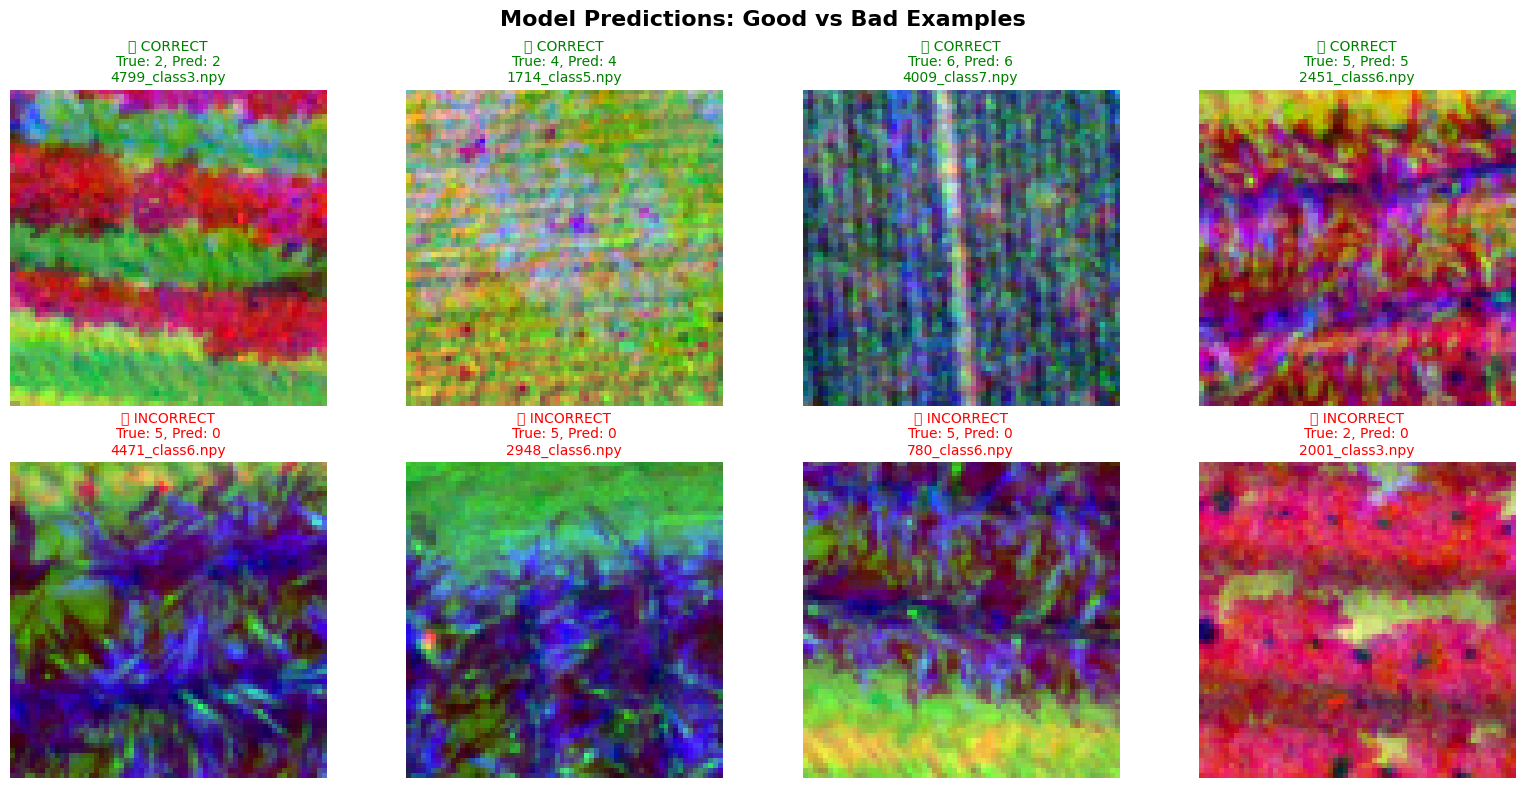


DETAILED ANALYSIS OF EXAMPLES

🟢 CORRECT PREDICTIONS:
  1. File: 4799_class3.npy
     True Label: 2 | Predicted: 2
  2. File: 1714_class5.npy
     True Label: 4 | Predicted: 4
  3. File: 4009_class7.npy
     True Label: 6 | Predicted: 6
  4. File: 2451_class6.npy
     True Label: 5 | Predicted: 5

🔴 INCORRECT PREDICTIONS:
  1. File: 4471_class6.npy
     True Label: 5 | Predicted: 0 (ERROR)
  2. File: 2948_class6.npy
     True Label: 5 | Predicted: 0 (ERROR)
  3. File: 780_class6.npy
     True Label: 5 | Predicted: 0 (ERROR)
  4. File: 2001_class3.npy
     True Label: 2 | Predicted: 0 (ERROR)

📊 SUMMARY:
Overall Test Accuracy: 97.88%
Correct Predictions: 554/566
Incorrect Predictions: 12/566


In [23]:
import numpy as np

import matplotlib.pyplot as plt

# Get some examples of good and bad predictions
correct_indices = [i for i in range(len(true_labels)) if true_labels[i] == predictions[i]]
incorrect_indices = [i for i in range(len(true_labels)) if true_labels[i] != predictions[i]]

print(f"Total correct predictions: {len(correct_indices)}")
print(f"Total incorrect predictions: {len(incorrect_indices)}")

# Select 4 good and 4 bad predictions
good_examples = correct_indices[:4] if len(correct_indices) >= 4 else correct_indices
bad_examples = incorrect_indices[:4] if len(incorrect_indices) >= 4 else incorrect_indices

print(f"Showing {len(good_examples)} good predictions and {len(bad_examples)} bad predictions")

# Function to load and display an image
def show_prediction_example(idx, is_correct=True):
    # Get the filename from test dataset
    filename = test_dataset.data.iloc[idx]['filename']
    true_label = true_labels[idx]
    pred_label = predictions[idx]
    
    # Load the image
    image_path = os.path.join(test_dataset.image_dir, filename)
    image_array = np.load(image_path)
    
    # Apply the same transform as used during testing
    image_tensor = torch.tensor(image_array, dtype=torch.float32)
    transformed_image = val_transform(image_tensor)
    
    return transformed_image, true_label, pred_label, filename

# Create the visualization
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Show good predictions
for i, idx in enumerate(good_examples):
    image, true_label, pred_label, filename = show_prediction_example(idx, True)
    
    # Show 3 different bands
    ax = axes[0, i]
    # Create RGB-like visualization using 3 different bands
    if image.shape[0] >= 3:
        rgb_image = np.stack([
            image[0].numpy(),  # Red channel
            image[image.shape[0]//2].numpy(),  # Green channel  
            image[-1].numpy()  # Blue channel
        ], axis=-1)
        # Normalize for display
        rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
        ax.imshow(rgb_image)
    else:
        ax.imshow(image[0].numpy(), cmap='gray')
    
    ax.set_title(f'✅ CORRECT\nTrue: {true_label}, Pred: {pred_label}\n{filename}', 
                 fontsize=10, color='green')
    ax.axis('off')

# Show bad predictions
for i, idx in enumerate(bad_examples):
    image, true_label, pred_label, filename = show_prediction_example(idx, False)
    
    # Show 3 different bands
    ax = axes[1, i]
    # Create RGB-like visualization using 3 different bands
    if image.shape[0] >= 3:
        rgb_image = np.stack([
            image[0].numpy(),  # Red channel
            image[image.shape[0]//2].numpy(),  # Green channel  
            image[-1].numpy()  # Blue channel
        ], axis=-1)
        # Normalize for display
        rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
        ax.imshow(rgb_image)
    else:
        ax.imshow(image[0].numpy(), cmap='gray')
    
    ax.set_title(f'❌ INCORRECT\nTrue: {true_label}, Pred: {pred_label}\n{filename}', 
                 fontsize=10, color='red')
    ax.axis('off')

# Hide unused subplots if we don't have enough examples
for i in range(len(good_examples), 4):
    axes[0, i].axis('off')
for i in range(len(bad_examples), 4):
    axes[1, i].axis('off')

plt.suptitle('Model Predictions: Good vs Bad Examples', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed information about the examples
print("\n" + "="*60)
print("DETAILED ANALYSIS OF EXAMPLES")
print("="*60)

print(f"\n🟢 CORRECT PREDICTIONS:")
for i, idx in enumerate(good_examples):
    filename = test_dataset.data.iloc[idx]['filename']
    true_label = true_labels[idx]
    pred_label = predictions[idx]
    print(f"  {i+1}. File: {filename}")
    print(f"     True Label: {true_label} | Predicted: {pred_label}")

print(f"\n🔴 INCORRECT PREDICTIONS:")
for i, idx in enumerate(bad_examples):
    filename = test_dataset.data.iloc[idx]['filename']
    true_label = true_labels[idx]
    pred_label = predictions[idx]
    print(f"  {i+1}. File: {filename}")
    print(f"     True Label: {true_label} | Predicted: {pred_label} (ERROR)")

print(f"\n📊 SUMMARY:")
print(f"Overall Test Accuracy: {test_accuracy:.2f}%")
print(f"Correct Predictions: {len(correct_indices)}/{len(true_labels)}")
print(f"Incorrect Predictions: {len(incorrect_indices)}/{len(true_labels)}")

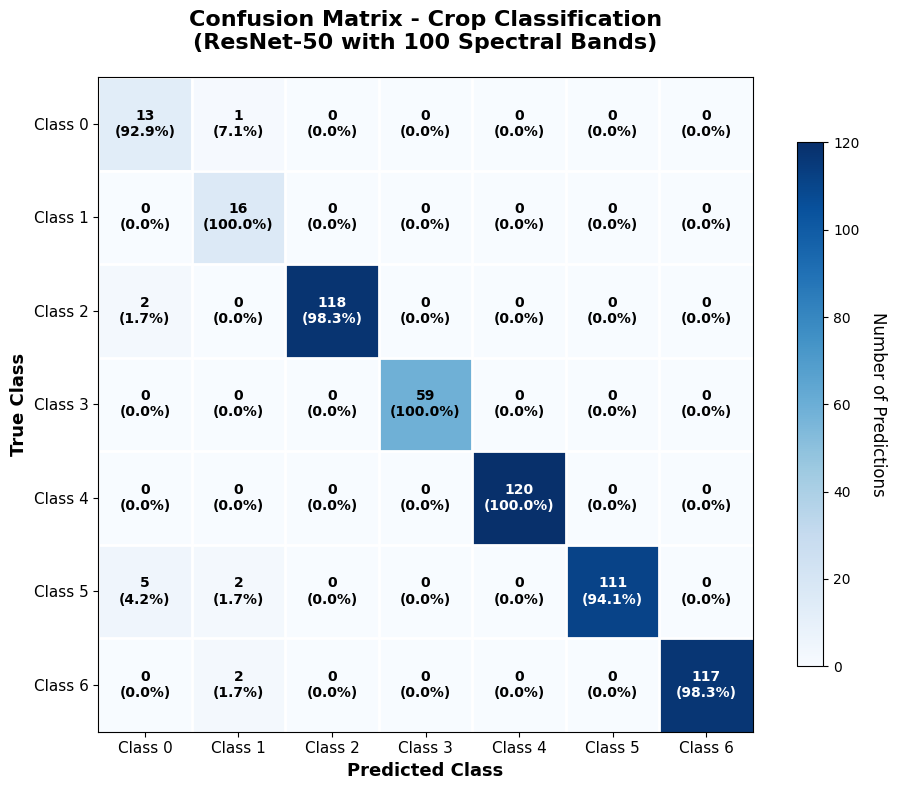

DETAILED CLASSIFICATION REPORT
Overall Test Accuracy: 97.88%
Total Test Samples: 566
Correct Predictions: 554
Incorrect Predictions: 12


In [26]:
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Create beautiful confusion matrix visualization
plt.figure(figsize=(10, 8))

# Create the heatmap
im = plt.imshow(cm, interpolation='nearest', cmap='Blues')

# Add colorbar
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Number of Predictions', rotation=270, labelpad=20, fontsize=12)

# Set title
plt.title('Confusion Matrix - Crop Classification\n(ResNet-50 with 100 Spectral Bands)', 
          fontsize=16, fontweight='bold', pad=20)

# Set labels
class_names = [f'Class {i}' for i in range(7)]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, fontsize=11)
plt.yticks(tick_marks, class_names, fontsize=11)
plt.xlabel('Predicted Class', fontsize=13, fontweight='bold')
plt.ylabel('True Class', fontsize=13, fontweight='bold')

# Add text annotations with numbers and percentages
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Calculate percentage
        percentage = cm[i, j] / cm[i, :].sum() * 100 if cm[i, :].sum() > 0 else 0
        
        # Choose text color based on background
        text_color = "white" if cm[i, j] > thresh else "black"
        
        # Add count and percentage
        plt.text(j, i, f'{cm[i, j]}\n({percentage:.1f}%)',
                ha="center", va="center", 
                color=text_color, fontsize=10, fontweight='bold')

# Add grid lines for better separation
for i in range(len(class_names)):
    plt.axhline(i-0.5, color='white', linewidth=2)
    plt.axvline(i-0.5, color='white', linewidth=2)


plt.tight_layout()
plt.show()

# Print detailed classification report
print("="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(f"Overall Test Accuracy: {accuracy:.2f}%")
print(f"Total Test Samples: {len(true_labels)}")
print(f"Correct Predictions: {np.trace(cm)}")
print(f"Incorrect Predictions: {len(true_labels) - np.trace(cm)}")

### TensorBoard Visualization

To view the TensorBoard logs, run the following command in your terminal:

```bash
tensorboard --logdir=tensorboard_logs
```

Then open your browser and go to `http://localhost:6006` to view:
- Training and validation loss curves
- Accuracy curves
- Learning rate changes
- Real-time training progress

TensorBoard provides interactive plots and allows you to:
- Compare different training runs
- Zoom into specific epochs
- Download plots as images
- Monitor training in real-time